In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import tab20, tab20c
import pandas as pd
import pyFAST.linearization.linearization as lin

In [2]:
prefix = 'NREL-2.8-127'
rotor_speed_step = 1.0 # [RPM]
BladeLen = 127./2 # [m]
TowerLen = 88.5 # [m]

In [3]:
# copied from `check_NREL-*-*.ipynb`
design_flap_freqs = [ 0.77067758,  2.53802981,  5.56382085,  9.87661714, 18.4960709]
design_edge_freqs = [ 1.16728376,  3.57798729,  8.29684599, 14.00542891, 15.27860799]
design_tower_fa_freqs = [0.23065896, 1.5273576,  3.4706556]
design_tower_ss_freqs = [0.22925678, 1.3657099,  3.34890514]

## automated postprocessing with `pyFAST`
to guess at modes

In [4]:
fstFiles = glob.glob('outputs/*.fst')
fstFiles.sort()
OP, Freq, Damp, UnMapped, ModeData, modeID_file = lin.postproCampbell(fstFiles, BladeLen, TowerLen)

run_pyMBC:
       Lin. files: outputs/000_0.0rpm.*.lin (1)
       Lin. files: outputs/001_1.0rpm.*.lin (36)
       Lin. files: outputs/002_2.0rpm.*.lin (36)
       Lin. files: outputs/003_3.0rpm.*.lin (36)
       Lin. files: outputs/004_4.0rpm.*.lin (36)
       Lin. files: outputs/005_5.0rpm.*.lin (36)
       Lin. files: outputs/006_6.0rpm.*.lin (36)
       Lin. files: outputs/007_7.0rpm.*.lin (36)
       Lin. files: outputs/008_8.0rpm.*.lin (36)
       Lin. files: outputs/009_9.0rpm.*.lin (36)
       Lin. files: outputs/010_10.0rpm.*.lin (36)
       Lin. files: outputs/011_11.0rpm.*.lin (36)
       Lin. files: outputs/012_12.0rpm.*.lin (36)
       Lin. files: outputs/013_13.0rpm.*.lin (36)
       Lin. files: outputs/014_14.0rpm.*.lin (36)


Reading csv file:  outputs/Campbell_OP.csv
Reading csv file:  outputs/Campbell_ModesID.csv


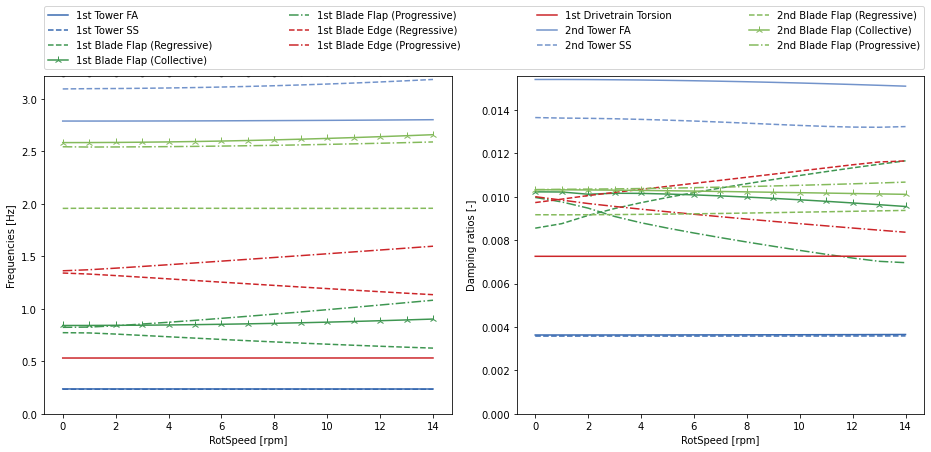

In [5]:
fig, axes, figName =  lin.plotCampbellDataFile(modeID_file, 'rpm')

In [6]:
# # fixes to mode identification
# def swap_modes(rpm,mode1,mode2):
#     mode1 = mode1.replace(' ','_')
#     mode2 = mode2.replace(' ','_')
#     # make sure we can select modes
#     selected_freq = Freq.loc[rpm,[mode1,mode2]]
#     selected_damp = Damp.loc[rpm,[mode1,mode2]]
#     # swap natural frequencies
#     old_freq1 = selected_freq[mode1]
#     Freq.loc[rpm,mode1] = selected_freq[mode2]
#     Freq.loc[rpm,mode2] = old_freq1
#     # swap damping ratios
#     old_damp1 = selected_damp[mode1]
#     Damp.loc[rpm,mode1] = selected_damp[mode2]
#     Damp.loc[rpm,mode2] = old_damp1

# swap_modes(14,'2nd Tower SS','2nd Blade Flap (Collective)')

## read operating points table

In [7]:
op = pd.read_csv(f'../{prefix}_openfast.csv').set_index('rotor speed [RPM]')
op = op.loc[op['Wind1VelX_[m/s]'] <= 11]
GenTorque = op['generator torque [kN-m]'] * 1000.
GenTorque.loc[0] = 1e-9
GenTorque.sort_index(inplace=True)
GenTorque.loc[16.0] = np.nan
GenTorque = GenTorque.fillna(method='ffill')

In [8]:
rotor_speeds = Freq.index
rotor_speeds_Hz = rotor_speeds / 60.

## final Campbell diagram

styles based on `tab20c`, grouping similar modes together

In [9]:
tab20c_colors = [tab20c(frac) for frac in np.linspace(0,1,20)]
modes_styles = {
    '1st Tower FA': dict(marker='^',color=tab20c_colors[0]), # blue1
    '1st Tower SS': dict(color=tab20c_colors[2]), # blue3
    '1st Blade Flap (Regressive)': dict(color=tab20c_colors[4]), # orange1
    '1st Drivetrain Torsion': dict(color=tab20c_colors[8]), # green1
    '1st Blade Flap (Collective)': dict(marker='o',color=tab20c_colors[5]), # orange2
    '1st Blade Flap (Progressive)': dict(color=tab20c_colors[6]), # orange3
    '1st Blade Edge (Regressive)': dict(color=tab20c_colors[12]), # purple1
    '1st Blade Edge (Progressive)': dict(color=tab20c_colors[14]), # purple3
    '2nd Blade Flap (Regressive)': dict(linestyle='--',color=tab20c_colors[4]), # orange1
    '2nd Blade Flap (Collective)': dict(marker='o',linestyle='--',color=tab20c_colors[5]), # orange2
    '2nd Blade Flap (Progressive)': dict(linestyle='--',color=tab20c_colors[7]), # orange4
    '2nd Tower FA': dict(linestyle='--',marker='^',color=tab20c_colors[0]), # blue1
    '2nd Tower SS': dict(linestyle='--',color=tab20c_colors[2]), # blue3    
}

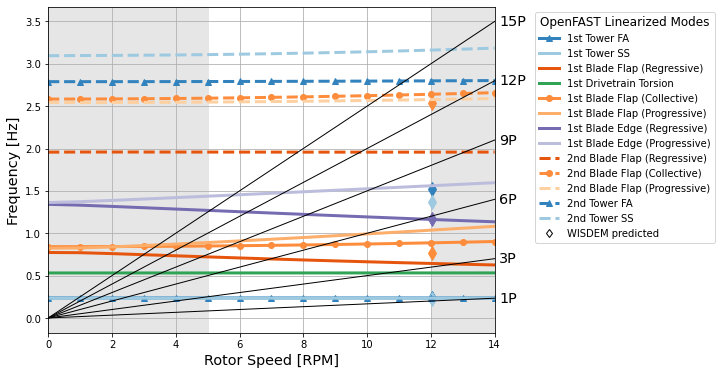

In [10]:
fig,ax = plt.subplots(figsize=(8,6))

# natural frequencies (from WISDEM)
ratedRPM = op.index.max()
markersize = 10
ax.plot(ratedRPM, design_tower_fa_freqs[0],'d',markersize=markersize,
        color=modes_styles['1st Tower FA']['color'])
ax.plot(ratedRPM, design_tower_ss_freqs[0],'d',markersize=markersize,
        color=modes_styles['1st Tower SS']['color'])
ax.plot(ratedRPM, design_flap_freqs[0],'d',markersize=markersize,
        color=modes_styles['1st Blade Flap (Collective)']['color'])
ax.plot(ratedRPM, design_edge_freqs[0],'d',markersize=markersize,
        color=tab20c_colors[12])
ax.plot(ratedRPM, design_flap_freqs[1],'d',markersize=markersize,
        color=modes_styles['2nd Blade Flap (Collective)']['color'])
ax.plot(ratedRPM, design_tower_fa_freqs[1],'d',markersize=markersize,
        color=modes_styles['2nd Tower FA']['color'])
ax.plot(ratedRPM, design_tower_ss_freqs[1],'d',markersize=markersize,
        color=modes_styles['2nd Tower SS']['color'])


# plot modes
#df.plot(ax=ax,marker='o') # uniform marker style, marker cycle ignored
#ax.get_legend().remove()

# for (i,mode),(name,style) in zip(df.iteritems(),
#                                  modes_styles.items()):
#     ax.plot(mode.index, mode, lw=3, label=name, **style)

for mode,style in modes_styles.items():
    df = Freq[mode.replace(' ','_')]
    ax.plot(df.index, df, lw=3, label=mode, **style)
    
# fan plot
for n in [1,3,6,9,12,15]:
    ax.plot(rotor_speeds, n*rotor_speeds_Hz, 'k-', lw=1)
    ax.text(1.01*rotor_speeds[-1], n*rotor_speeds_Hz[-1], f'{n}P',
            fontsize='x-large', verticalalignment='center')

ax.plot(rotor_speeds[-1]+1,0,'kd',mfc='None',label='WISDEM predicted')

# indicate operational range
ax.axvspan(rotor_speeds[0], op.index.min(), color='0.9')
ax.axvspan(op.index.max(), rotor_speeds[-1], color='0.9')

# other formatting
ax.set_xlim((rotor_speeds[0],rotor_speeds[-1]))
ax.grid()
ax.legend(loc='upper left',bbox_to_anchor=(1.08,1),
          title='OpenFAST Linearized Modes',
          title_fontsize='large')
ax.set_xlabel('Rotor Speed [RPM]',fontsize='x-large')
ax.set_ylabel('Frequency [Hz]',fontsize='x-large')

fig.savefig(f'{prefix}_Campbell_diagram.png',bbox_inches='tight')

In [11]:
# approx 1st tower freq [Hz]
Freq['1st_Tower_FA'].mean()

0.23662933333333333

In [12]:
# margin at cutout
Freq.loc[op.index[-1].round(),'1st_Tower_FA'] / (op.index[-1]/60)

1.1782301030438103

In [13]:
# margin at cutin
Freq.loc[op.index[0].round(),'1st_Tower_FA'] / (3*(op.index[0]/60))

0.9469781021240872